Opmerking. Bij de ingevoerde teksten werd de abstract uitgesloten.

Prompts:

### ChatGPT

poging 1 -->
``Schrijf dit in hoogstens zes Nederlandstalige paragrafen waarvan elk vijf zinnen die niet langer dan tien woorden zijn. Gebruik niet meer dan 500 woorden.
vervang moeilijke woorden door één eenvoudiger synoniem, regelmatige woordenschat, schrijf cijfermateriaal voluit, schrijf acroniemen voluit
vermijd tangconstructies, voorzetsel- en verwijswoorden``

Deze prompt met alle tekst uit de paper resulteerde in een foutmelding. De tokenlimiet werd bereikt.

poging 2 --> 

De paper werd op systematische wijze in twee opgebroken. Het eerste deel was teksinhoud van pagina 2 tot en met 5. Het tweede deel strijkte van pagina 6 tot en met 8. Deze prompt leidde ook tot een foutmelding.

poging 3 -->

De paper werd op systematische wijze in drie delen opgebroken van elk twee pagina's lang. 

### SciSpace

poging 1 -->

``Vat deze volledige paper samen in hoogstens zes paragrafen waarvan elke vijf zinnen niet langer zijn dan tien woorden. Gebruik niet meer dan 500 woorden. vervang moeilijke woorden door één eenvoudiger synoniem, regelmatige woordenschat, schrijf cijfermateriaal voluit, schrijf acroniemen voluitvermijd tangconstructies, voorzetsel- en verwijswoorden``

Deze prompt resulteerde in een foutmelding. De tool is niet in staat om een volledige paper volgens deze richtlijnen te samenvatten. 

poging 2 -->

De volledige tekst werd geselecteerd. De tool biedt een optie aan om geselecteerde tekst samen te vatten. Een foutmelding werd teruggegeven, maar zonder indicatie waarom de tool geen antwoord kan teruggeven. 

poging 3 --> 

De gemarkeerde tekst werd gereduceerd tot tekstinhoud van twee pagina's. De samenvatknop werkte dit keer wel. De gebruiker kan expliciet aangeven in welke taal de samengevatte tekst moet zijn.

### Resoomer

Resoomer is niet in staat om prompts te verwerken. Enkel de richtlijn rond totaallengte van het document kan expliciet worden behandeld door de gebruiker. Over lexicale en syntactische vereenvoudiging heeft de gebruiker geen zeggen.

In [15]:
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LTChar
import os

# PDF's ophalen

## Oorspronkelijke teksten

In [16]:
folder_path = 'pdf'
pdf_files = [f for f in os.listdir(folder_path) if f.endswith('.pdf')]

In [17]:
all_pages = extract_pages(
    pdf_file='pdf/'+pdf_files[0],
    page_numbers=[0],
    maxpages=999
)

full_text_old = ""

for page_layout in all_pages:
    for element in page_layout:
        if isinstance(element, LTTextContainer):
            for text_line in element:
                full_text_old += text_line.get_text()

# Cleaning

In [18]:
full_text_old = full_text_old.strip()

In [19]:
full_text_old[:10]

'VIRTUAL RE'

In [20]:
len(full_text_old)

1867

In [21]:
import spacy
from langdetect import detect
import pandas as pd

dutch_spacy_model = "nl_core_news_md"

nlp = spacy.load(dutch_spacy_model) if detect(full_text_old) == 'nl' else spacy.load("en_core_word_md")
doc = nlp(full_text_old)

sentences = []

for sentence in doc.sents:
    sentences.append(str(sentence))


In [22]:
df_old = pd.DataFrame(sentences, columns=['sentence'])

In [23]:
df_old.head()

,sentence
0,VIRTUAL REALITY IN STOTTERTHERAPIE
1,BIJ \n(JONG)
2,"VOLWASSENEN \nJana Van Dammea, Hermien De Baen..."
3,"HOGENT, Onderzoeker 360"
4,°


In [24]:
def get_sentence_length(sentence):
    doc = nlp(sentence)
    return len(doc)

In [25]:
df_old['sentence_length'] = df_old['sentence'].apply(get_sentence_length)

In [26]:
df_old.head()

,sentence,sentence_length
0,VIRTUAL REALITY IN STOTTERTHERAPIE,4
1,BIJ \n(JONG),5
2,"VOLWASSENEN \nJana Van Dammea, Hermien De Baen...",25
3,"HOGENT, Onderzoeker 360",4
4,°,1


In [27]:
df_old = df_old[df_old['sentence_length'] > 3]

In [28]:
import readability

for key in readability.getmeasures("test")['readability grades'].keys():
    df_old[key] = df_old['sentence'].apply(lambda x: readability.getmeasures(x)['readability grades'][key])

In [29]:
df_old.head()

,sentence,sentence_length,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex
0,VIRTUAL REALITY IN STOTTERTHERAPIE,4,-14.030000,17.072500,22.371221,202.77500,1.600000,79.000000,3.000000,3.00,15.677400
1,BIJ \n(JONG),5,-15.200000,-4.445000,-24.808605,205.82000,0.400000,1.000000,3.000000,0.00,19.476100
2,"VOLWASSENEN \nJana Van Dammea, Hermien De Baen...",25,9.862500,10.940263,15.415662,32.81375,6.110526,52.118421,6.872983,2.25,18.831047
3,"HOGENT, Onderzoeker 360",4,-2.620000,11.470000,13.535776,119.19000,1.200000,36.333333,3.000000,1.00,19.575300
5,"Zorg en Welzijn, stottertherapeut Huis \nvoor",8,7.213333,9.115000,10.595851,48.69000,7.866667,36.333333,6.872983,1.00,19.575300


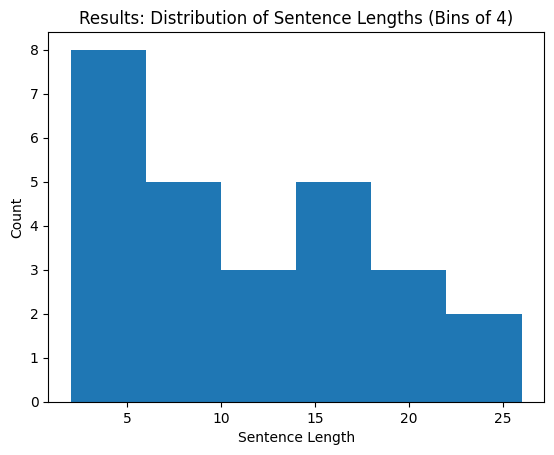

In [30]:
import matplotlib.pyplot as plt

bin_size = 4
df_old['bin_sentence'] = (df_old['sentence_length'] // bin_size) * bin_size

grouped = df_old.groupby('bin_sentence')['bin_sentence'].count().reset_index(name='count')

plt.bar(grouped['bin_sentence'], grouped['count'], width=bin_size)
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.title('Results: Distribution of Sentence Lengths (Bins of 4)')
plt.show()

# Zinsconstructies.

In [31]:
word_usage_cols = readability.getmeasures("test")['word usage'].keys()
for key in word_usage_cols:
    df_old[key] = df_old['sentence'].apply(lambda x: readability.getmeasures(x, lang='nl')['word usage'][key])

In [32]:
sentence_beginnings_cols = readability.getmeasures("test")['sentence beginnings'].keys()
for key in sentence_beginnings_cols:
    df_old[key] = df_old['sentence'].apply(lambda x: readability.getmeasures(x, lang='nl')['sentence beginnings'][key])

In [33]:
df_old.head(4)

,sentence,sentence_length,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,...,bin_sentence,tobeverb,auxverb,conjunction,pronoun,preposition,nominalization,interrogative,article,subordination
0,VIRTUAL REALITY IN STOTTERTHERAPIE,4,-14.0300,17.072500,22.371221,202.77500,1.600000,79.000000,3.000000,3.00,...,4,0,0,0,0,0,0,0,0,0
1,BIJ \n(JONG),5,-15.2000,-4.445000,-24.808605,205.82000,0.400000,1.000000,3.000000,0.00,...,4,0,0,0,0,1,0,0,0,0
2,"VOLWASSENEN \nJana Van Dammea, Hermien De Baen...",25,9.8625,10.940263,15.415662,32.81375,6.110526,52.118421,6.872983,2.25,...,24,0,0,0,0,0,0,0,0,0
3,"HOGENT, Onderzoeker 360",4,-2.6200,11.470000,13.535776,119.19000,1.200000,36.333333,3.000000,1.00,...,4,0,0,0,0,0,0,0,0,0


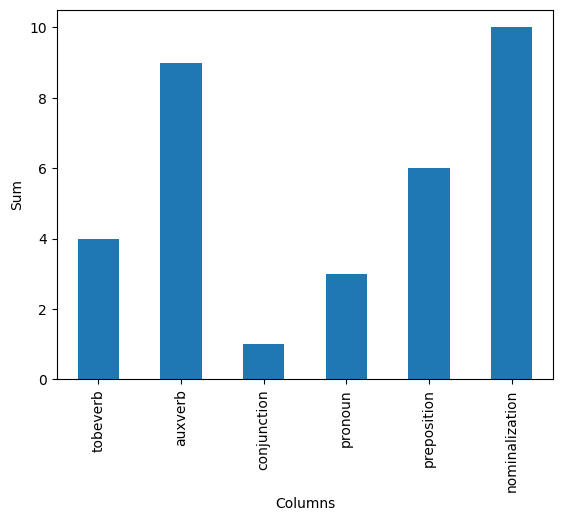

In [34]:
word_usage_sum = df_old[word_usage_cols].sum()
word_usage_sum.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Sum')
plt.show()

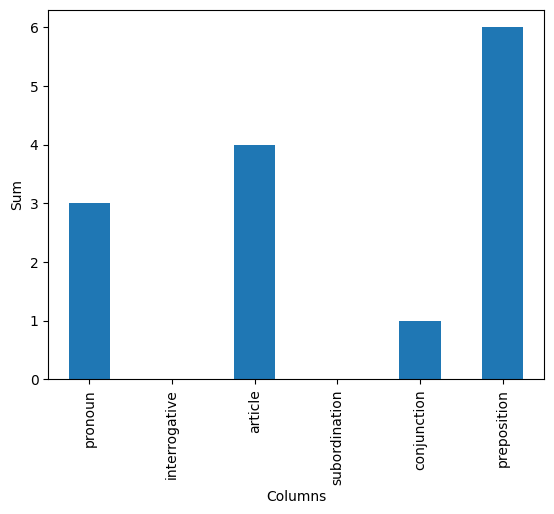

In [35]:
sentence_beginnings_sum = df_old[sentence_beginnings_cols].sum()
sentence_beginnings_sum.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Sum')
plt.show()